# Training Samples construction
This notebook contains the example code of construct the positive and negative pairs for the constrastive learning as in the GCNv2-SLAM.

In [1]:
# package need to be installed
# pip install ipykernel
# pip install opencv-python
# pip install scikit-learn

In [2]:
# import packages
import os
import numpy as np
import re
import cv2
from sklearn.neighbors import NearestNeighbors
import h5py
import torch
import matplotlib.pyplot as plt

In [3]:
# path defination
# Get the current working directory
current_directory = os.getcwd()

# define correct sequence
sequence_name="brown_bm_1/brown_bm_1"

# Construct relative file paths
dataset_path = os.path.join(current_directory, os.pardir, os.pardir,'sun3d_extracted')
seq_read_path=os.path.join(dataset_path,sequence_name)
img_read_path=os.path.join(seq_read_path,'img')
depth_read_path=os.path.join(seq_read_path,'depth')
intrinsics_path=os.path.join(seq_read_path,'intrinsics.txt')
poses_path=os.path.join(seq_read_path,'relative_transformations.txt')


output_path = os.path.join(current_directory, os.pardir, os.pardir,'sun3d_training')
seq_out_path=os.path.join(output_path,sequence_name)
img_out_path=os.path.join(seq_out_path,'img')

In [4]:
# create folders
os.makedirs(output_path, exist_ok=True)
os.makedirs(seq_out_path, exist_ok=True)
os.makedirs(img_out_path, exist_ok=True)

In [5]:
def list_image_files(directory, extensions=['.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff']):
    """
    Lists all image files in a specified directory.

    :param directory: The directory to search for image files.
    :param extensions: A list of image file extensions to include.
    :return: A list of paths to image files in the directory.
    """
    image_files = []
    for filename in os.listdir(directory):
        if any(filename.endswith(extension) for extension in extensions):
            image_files.append(os.path.join(directory, filename))
    return image_files

In [6]:
# Function to process a single line of the pose file
def process_line(line):
    # Split the line into values and convert them to floats
    values = [float(value) for value in line.split()]
    # the line is in the format "R R R t R R R t R R R t", 
    # where R represents rotation matrix elements and t represents translation vector elements,
    pose = [values[0:4], values[4:8], values[8:12]]
    return pose

In [7]:
# load all img and depth file name
imgs=list_image_files(img_read_path)
depths=list_image_files(depth_read_path)

# Read the intrinsics file into a NumPy array (matrix)
intrinsics_matrix = np.loadtxt(intrinsics_path)

# Read the pose file and process each line
with open(poses_path, 'r') as file:
    poses = [process_line(line) for line in file]

In [8]:
def sort_key(filename):
    """
    Custom sort function to extract the numerical part at the beginning of the filename
    and use it as the sorting key.
    """
    match = re.match(r'(\d+)', os.path.basename(filename))
    if match:
        return int(match.group(1))
    return 0  # Default value if no match is found

In [9]:
# make sure the filenames are in correct order
imgs = sorted(list_image_files(img_read_path), key=sort_key)
depths = sorted(list_image_files(depth_read_path), key=sort_key)

In [10]:
# Function to create pairs of neighboring files
def create_neighboring_pairs(files):
    return [(files[i], files[i+1]) for i in range(len(files) - 1)]

In [11]:
# Create pairs for images and depths
img_pairs = create_neighboring_pairs(imgs)
depth_pairs = create_neighboring_pairs(depths)

In [12]:
def build_training_pairs(img_pairs, depth_pairs, relative_poses, 
                         intrinsics_matrix, k=2, distance_threshold=30,
                         positive_pairs=None, negative_pairs=None):
    if positive_pairs is None:
        positive_pairs = []
    if negative_pairs is None:
        negative_pairs = []
    
    sift = cv2.SIFT_create()

    for ((img1_path, img2_path), (depth1_path, depth2_path), pose) in zip(img_pairs, depth_pairs, relative_poses):
        # Load images and depth maps
        img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
        img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)
        depth1 = cv2.imread(depth1_path, cv2.IMREAD_UNCHANGED)

        # Ensure the depth image is of unsigned 16-bit type, which is expected for depth images
        if depth1.dtype == np.uint16:
        # Perform the bit manipulation operation on the entire array
            depth1 = np.bitwise_or(np.left_shift(depth1, 13), np.right_shift(depth1, 3))
        else:
            print("Depth image is not in the expected format.")
        
        # Step 1: Extract SIFT features from the first image
        keypoints1, descriptors1 = sift.detectAndCompute(img1, None)

        # Convert keypoints to an array
        points1 = cv2.KeyPoint_convert(keypoints1)

        # Step 2 & 3: Convert 2D points to 3D and transform them according to the relative pose
        filtered_points1,points3D = convert_to_3d(points1, depth1, intrinsics_matrix)
        transformed_points3D = transform_points(points3D, pose)

        # Step 4: Reproject to the second image    
        img2_shape = img2.shape[:2]
        filtered_points, filtered_reprojected_points2 = reproject_and_filter(filtered_points1, transformed_points3D, intrinsics_matrix, img2_shape)

        # Check if reprojected points are empty
        if filtered_reprojected_points2.size == 0:
            print("No reprojected points within image bounds. Skipping this pair.")
            continue  # Skip the rest of the loop and proceed to the next iteration
        
        # Step 5: For negative pairs, find distant features in the second image
        keypoints2, descriptors2 = sift.detectAndCompute(img2, None)
        points2 = cv2.KeyPoint_convert(keypoints2)
        
        # print("Points2D shape:", points2.shape)
        # print("Filtered Points1 shape:", filtered_points1.shape)
        # print("Transformed Points3D shape:", transformed_points3D.shape)
        # print("Reprojected Points2 shape:", filtered_reprojected_points2.shape)

        
        # Find nearest features and filter out to form negative pairs
        negative_points2 = negative_sample_mining(points2, filtered_reprojected_points2, k, distance_threshold)
        
        # Store positive and negative pairs with image path information
        positive_pairs.append({
            'img_paths': (img1_path, img2_path),
            'points1': filtered_points,
            'points2': filtered_reprojected_points2
        })
        negative_pairs.append({
            'img_paths': (img1_path, img2_path),
            'points1': filtered_points,  # Assuming you want to keep points1 consistent with positive_pairs
            'points2': negative_points2
        })

    return positive_pairs, negative_pairs

def convert_to_3d(points2D, depth, intrinsics):
    """
    Convert 2D points to 3D using depth information (scaled by 1/1000 to convert to meters) 
    and camera intrinsics.
    
    :param points2D: Array of 2D points obtained from keypoints (N, 2)
    :param depth: Depth image, depth values are in millimeters
    :param intrinsics: Camera intrinsic matrix (3, 3)
    :return: Array of 3D points (N, 3)
    """
    #points3D = []
    
    # Intrinsic matrix parameters
    fx = intrinsics[0, 0]
    fy = intrinsics[1, 1]
    cx = intrinsics[0, 2]
    cy = intrinsics[1, 2]
    
    # for x, y in points2D:
    #     # Get the depth for the current point and convert it to meters
    #     z = depth[int(y), int(x)] / 1000.0  # Convert depth from mm to meters
        
    #     # Discard points with non-positive depth
    #     if z <= 0:
    #         continue
        
    #     # Convert the 2D point to 3D using the intrinsic parameters and the depth
    #     X = (x - cx) * z / fx
    #     Y = (y - cy) * z / fy
    #     Z = z
        
    #     # Add the 3D point to the list
    #     points3D.append([X, Y, Z])
    # Extract depth values for each point, converting depth from mm to meters
    z = depth[points2D[:, 1].astype(int), points2D[:, 0].astype(int)] / 1000.0
    valid = z > 0

    
    # Filter points2D based on valid mask
    filtered_points2D = points2D[valid]
    
    # Compute 3D coordinates
    x = (points2D[:, 0][valid] - cx) * z[valid] / fx
    y = (points2D[:, 1][valid] - cy) * z[valid] / fy
    points3D = np.vstack((x, y, z[valid])).T
    
    # return np.array(points3D)
    return filtered_points2D, points3D

def transform_points(points3D, pose):
    """
    Apply the relative pose transformation to 3D points.
    
    :param points3D: Array of 3D points (N, 3)
    :param pose: Relative pose transformation matrix (4, 4)
    :return: Array of transformed 3D points (N, 3)
    """
    # Convert 3D points to homogeneous coordinates by adding a column of ones
    points_homogeneous = np.hstack((points3D, np.ones((points3D.shape[0], 1))))
    
    pose_3x4 = np.array(pose)

    # Convert the 3x4 pose matrix to a 4x4 transformation matrix
    T = np.vstack((pose_3x4, [0, 0, 0, 1]))
    
    # Apply the transformation matrix to each point
    transformed_points_homogeneous = np.dot(points_homogeneous, T)
    
    # Convert back from homogeneous to 3D coordinates by dividing by the last element
    transformed_points3D = transformed_points_homogeneous[:, :3] / transformed_points_homogeneous[:, 3, np.newaxis]
    
    return transformed_points3D


# def reproject_to_image(points3D, intrinsics):
#     """
#     Reproject 3D points back to 2D using camera intrinsics.
    
#     :param points3D: Array of 3D points (N, 3)
#     :param intrinsics: Camera intrinsic matrix (3, 3)
#     :return: Array of 2D points (N, 2)
#     """
#     # Extract intrinsic parameters
#     fx, fy = intrinsics[0, 0], intrinsics[1, 1]
#     cx, cy = intrinsics[0, 2], intrinsics[1, 2]
    
#     # Reproject each 3D point to 2D
#     points2D = np.zeros((points3D.shape[0], 2))
#     for i, (X, Y, Z) in enumerate(points3D):
#         x = (fx * X / Z) + cx
#         y = (fy * Y / Z) + cy
#         points2D[i] = [x, y]
    
#     return points2D

def reproject_and_filter(points2D, points3D_transformed, intrinsics, img2_shape):
    """
    Reproject transformed 3D points back to the second image and filter out points outside the image bounds.
    
    :param points2D: Original 2D points from the first image (N, 2)
    :param points3D_transformed: Transformed 3D points to be reprojected (N, 3)
    :param intrinsics: Camera intrinsic matrix (3, 3)
    :param img2_shape: Shape of the second image (height, width)
    :return: Filtered 2D points in both images (N', 2)
    """
    # Reproject the transformed 3D points to the second image
    # reprojected_points2 = reproject_to_image(points3D_transformed, intrinsics)
    
    # # Initialize lists to hold filtered points
    # filtered_points1 = []
    # filtered_reprojected_points2 = []
    
    # # Image dimensions
    # img2_height, img2_width = img2_shape
    
    # for point1, point2 in zip(points2D, reprojected_points2):
    #     x2, y2 = point2
    #     # Check if the reprojected point is within the image bounds
    #     if 0 <= x2 < img2_width and 0 <= y2 < img2_height:
    #         filtered_points1.append(point1)
    #         filtered_reprojected_points2.append(point2)
    
    # return np.array(filtered_points1), np.array(filtered_reprojected_points2)
    # Reproject the transformed 3D points to 2D
    fx, fy = intrinsics[0, 0], intrinsics[1, 1]
    cx, cy = intrinsics[0, 2], intrinsics[1, 2]
    x = (fx * points3D_transformed[:, 0] / points3D_transformed[:, 2]) + cx
    y = (fy * points3D_transformed[:, 1] / points3D_transformed[:, 2]) + cy
    reprojected_points2 = np.vstack((x, y)).T

    # Check bounds and filter points
    img2_height, img2_width = img2_shape
    valid = (x >= 0) & (x < img2_width) & (y >= 0) & (y < img2_height)
    
    return points2D[valid], reprojected_points2[valid]

def negative_sample_mining(points2, reprojected_points, k, threshold):
    """
    Find features in 'points2' that are the most distant from 'reprojected_points',
    subject to being farther away than 'threshold'. If all k nearest neighbors are
    closer than 'threshold', return the most distant one among them.

    :param points2: Detected SIFT features in the second image (M, 2)
    :param reprojected_points: Reprojected points in the second image (N, 2)
    :param k: Number of nearest neighbors to consider
    :param threshold: Distance threshold for considering a point as distant
    :return: Distant features from 'points2'
    """
    distant_features = []
    
    # Initialize NearestNeighbors with k neighbors
    nn = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(points2)
    
    # Find k nearest neighbors for each reprojected point
    distances, indices = nn.kneighbors(reprojected_points)
    
    # Iterate through each reprojected point and its neighbors
    for reproj_point_idx, (dist, idx) in enumerate(zip(distances, indices)):
        # Filter out neighbors closer than the threshold and find the farthest
        distant_idx = np.argmax(dist)  # Index of the farthest neighbor
        if dist[distant_idx] < threshold:
            # If the farthest is closer than the threshold, still consider it as a negative feature
            distant_features.append(points2[idx[distant_idx]])
        else:
            # If there's any neighbor farther than the threshold, consider the farthest among them
            distant_filtered_indices = idx[dist >= threshold]
            if len(distant_filtered_indices) > 0:
                # Append the feature that is farthest among those beyond the threshold
                distant_features.append(points2[distant_filtered_indices[np.argmax(dist[dist >= threshold])]])
            else:
                # If no features are beyond the threshold, append the farthest among the k nearest
                distant_features.append(points2[idx[distant_idx]])

    return np.array(distant_features)


In [13]:
positive_pairs, negative_pairs=build_training_pairs(img_pairs,depth_pairs,poses,intrinsics_matrix)

No reprojected points within image bounds. Skipping this pair.
No reprojected points within image bounds. Skipping this pair.


In [14]:
def save_pairs_to_hdf5(positive_pairs, negative_pairs, hdf5_file_path):
    with h5py.File(hdf5_file_path, 'a') as hdf:  # Open file in append mode
        # Check for the existence of groups and create if they don't exist
        if 'positive_pairs' not in hdf:
            pos_group = hdf.create_group('positive_pairs')
        else:
            pos_group = hdf['positive_pairs']
            
        if 'negative_pairs' not in hdf:
            neg_group = hdf.create_group('negative_pairs')
        else:
            neg_group = hdf['negative_pairs']

        # Function to generate a unique pair name based on existing ones
        def generate_pair_name(existing_names):
            i = 0
            while True:
                name = f'pair_{i}'
                if name not in existing_names:
                    return name
                i += 1

        # Append positive pairs
        existing_pos_names = set(pos_group.keys())
        for pair in positive_pairs:
            pair_name = generate_pair_name(existing_pos_names)
            pair_group = pos_group.create_group(pair_name)
            pair_group.create_dataset('img_paths', data=np.array(pair['img_paths'], dtype=h5py.string_dtype()))
            pair_group.create_dataset('points1', data=np.array(pair['points1']))
            pair_group.create_dataset('points2', data=np.array(pair['points2']))
            existing_pos_names.add(pair_name)  # Update existing names

        # Append negative pairs
        existing_neg_names = set(neg_group.keys())
        for pair in negative_pairs:
            pair_name = generate_pair_name(existing_neg_names)
            pair_group = neg_group.create_group(pair_name)
            pair_group.create_dataset('img_paths', data=np.array(pair['img_paths'], dtype=h5py.string_dtype()))
            pair_group.create_dataset('points1', data=np.array(pair['points1']))
            pair_group.create_dataset('points2', data=np.array(pair['points2']))
            existing_neg_names.add(pair_name)  # Update existing names

In [15]:
# Define the full path to the HDF5 file within the output directory
hdf5_file_path = os.path.join(output_path, 'pairs.hdf5')

save_pairs_to_hdf5(positive_pairs, negative_pairs, hdf5_file_path)

In [16]:
def load_pairs_from_hdf5(hdf5_file_path):
    with h5py.File(hdf5_file_path, 'r') as hdf:
        loaded_positive_pairs = []
        loaded_negative_pairs = []

        # Load positive pairs
        pos_group = hdf['positive_pairs']
        for pair_name in pos_group:
            pair_group = pos_group[pair_name]
            img_paths_array = pair_group['img_paths'][()]  # This will be a NumPy array
            img_paths = tuple(img_paths_array)  # Convert the NumPy array to a tuple
            points1 = torch.tensor(pair_group['points1'][()])
            points2 = torch.tensor(pair_group['points2'][()])
            loaded_positive_pairs.append({'img_paths': img_paths, 'points1': points1, 'points2': points2})

        # Load negative pairs
        neg_group = hdf['negative_pairs']
        for pair_name in neg_group:
            pair_group = neg_group[pair_name]
            img_paths_array = pair_group['img_paths'][()]  # This will be a NumPy array
            img_paths = tuple(img_paths_array)  # Convert the NumPy array to a tuple
            points1 = torch.tensor(pair_group['points1'][()])
            points2 = torch.tensor(pair_group['points2'][()])
            loaded_negative_pairs.append({'img_paths': img_paths, 'points1': points1, 'points2': points2})

    return loaded_positive_pairs, loaded_negative_pairs

In [23]:

def visualize_pairs(positive_pairs, negative_pairs):
    # Load the first image from the first positive pair and negative pair
    if positive_pairs and negative_pairs:
        pos_img_path = positive_pairs[0]['img_paths'][0].decode('utf-8')  # Decode the byte string
        neg_img_path = negative_pairs[0]['img_paths'][0].decode('utf-8')  # Decode the byte string
    else:
        print("No pairs to display.")
        return
    
    pos_img = cv2.imread(pos_img_path, cv2.IMREAD_COLOR)
    pos_img = cv2.cvtColor(pos_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for Matplotlib

    neg_img = cv2.imread(neg_img_path, cv2.IMREAD_COLOR)
    neg_img = cv2.cvtColor(neg_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for Matplotlib

    # Combine the images horizontally
    combined_img = np.hstack((pos_img, neg_img))

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(combined_img)

    # Draw green lines for positive pairs
    for pair in positive_pairs:
        if pair['img_paths'][0].decode('utf-8') == pos_img_path:
            for p1, p2 in zip(pair['points1'], pair['points2']):
                ax.plot([p1[0], p2[0] + pos_img.shape[1]], [p1[1], p2[1]], 'g-', linewidth=1)

    # Draw red lines for negative pairs
    for pair in negative_pairs:
        if pair['img_paths'][0].decode('utf-8') == neg_img_path:
            for p1, p2 in zip(pair['points1'], pair['points2']):
                ax.plot([p1[0], p2[0] + neg_img.shape[1]], [p1[1], p2[1]], 'r-', linewidth=1)

    ax.axis('off')
    plt.show()

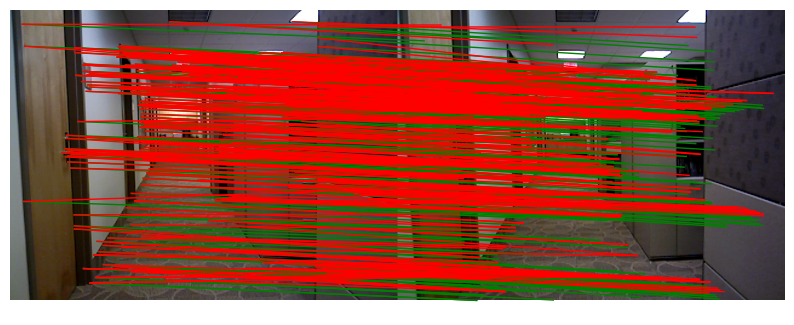

In [24]:
loaded_positive_pairs, loaded_negative_pairs= load_pairs_from_hdf5(hdf5_file_path)

visualize_pairs(loaded_positive_pairs, loaded_negative_pairs)